In [1]:
import re
import networkx as nx
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../week4/dataset/H113.csv')
wiki_page_names = list(df.WikiPageName)

In [3]:
class Politician:
    def __init__(self, dfRow):
        self.WikiPageName = str(dfRow[0])
        self.Party = str(dfRow[1])
        self.State = str(dfRow[2])
    def __hash__(self):
        return hash(self.WikiPageName)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.WikiPageName == other.WikiPageName
               )

In [4]:
def get_article_links(name, year):
    # The regex pattern for recognizing links on the form [x | y]
    # and only capturing 'x'.
    article_pattern = r'\[\[([^\]]*?)(?:\|.*?)*\]\]'
    path_folder = '../week4/WikiPages%s/' % year
    article = io.open(path_folder + name + year + ".txt", 'r').read()
    article_links = re.findall(article_pattern, article)
    article_links = [a.replace(' ', '_') for a in article_links]
    return article_links

In [6]:
congressGraph = nx.DiGraph()

for index, row in df.iterrows():
    # Create politician node
    p = Politician(row)
    congressGraph.add_node(p)
    
    # Get links
    wikiPageName = row[0]
    articleLinks = get_article_links(wikiPageName, "2015")
    for link in articleLinks:
        if link in wiki_page_names:
            linkIndex = wiki_page_names.index(link)
            linkRow = df.iloc[linkIndex]
            q = Politician(linkRow)
            congressGraph.add_edge(p, q)

In [7]:
def degree_array(G, direction="none"):
    if direction == "in":
        return list(dict(G.in_degree()).values())
    elif direction == "out":
        return list(dict(G.out_degree()).values())
    else:
        return list(dict(G.degree()).values())

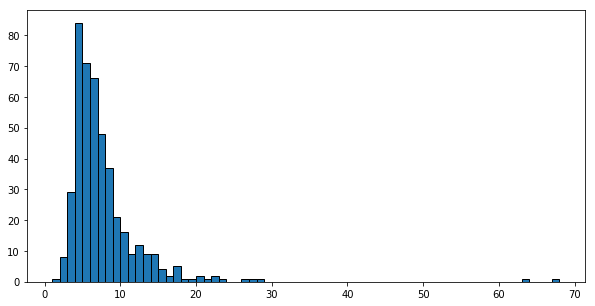

In [15]:
degrees = degree_array(congressGraph)
v = np.arange(min(degrees), max(degrees)+1)
plt.figure(figsize=(10,5))
plt.hist(degrees, bins=v, edgecolor="black")
plt.show()